<a href="https://colab.research.google.com/github/drcjaudet/Deconvolution3D/blob/master/CodePourCycy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Noise2Noise



In [2]:
!pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 16.4 MB/s eta 0:00:00


Epoch [1/10], Loss: 0.1909
Epoch [2/10], Loss: 0.1828
Epoch [3/10], Loss: 0.1749
Epoch [4/10], Loss: 0.1665
Epoch [5/10], Loss: 0.1572
Epoch [6/10], Loss: 0.1465
Epoch [7/10], Loss: 0.1339
Epoch [8/10], Loss: 0.1190
Epoch [9/10], Loss: 0.1012
Epoch [10/10], Loss: 0.0804


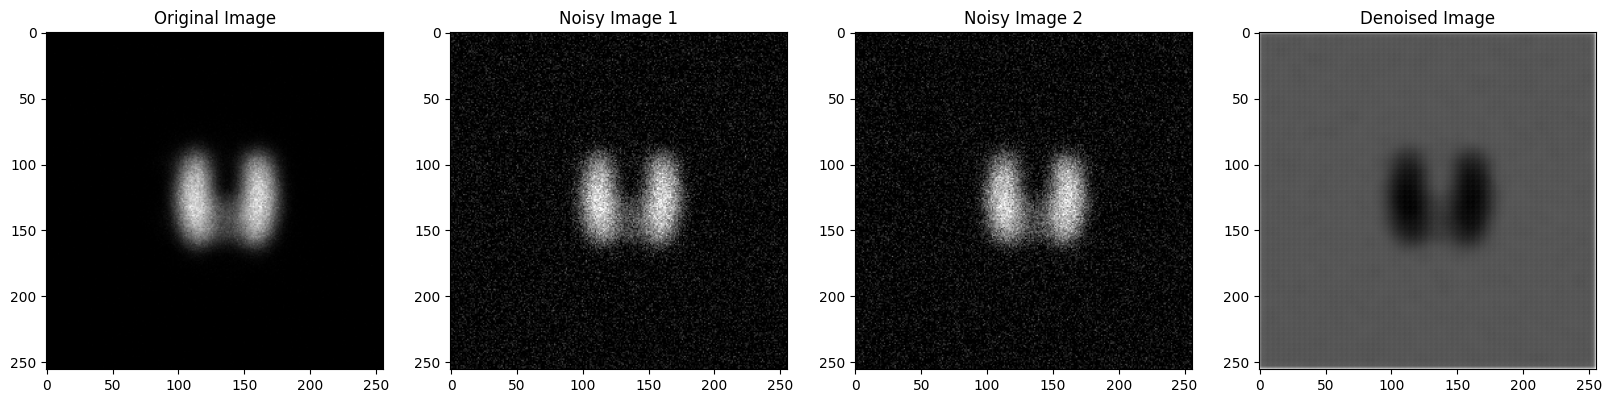

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pydicom
from torchvision import transforms

# Load a DICOM image
def load_dicom_image(file_path):
    dicom = pydicom.dcmread(file_path)
    img = dicom.pixel_array
    img = np.expand_dims(img, axis=0)  # Add channel dimension
    img = img / np.max(img)  # Normalize to [0, 1]
    return torch.tensor(img, dtype=torch.float32)

# Add Gaussian-Poisson noise to the image
def add_gaussian_poisson_noise(image, sigma=0.1):
    noise = torch.normal(mean=0.0, std=sigma, size=image.size())
    noisy_image = image + noise
    noisy_image = torch.clamp(noisy_image, min=0.0, max=1.0)  # Ensure pixel values are in [0, 1]
    return noisy_image

# Define a simple convolutional autoencoder for denoising
class Noise2NoiseNet(nn.Module):
    def __init__(self):
        super(Noise2NoiseNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 64, kernel_size=2, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()  # Ensure output values are in [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Load and preprocess the DICOM image
dicom_file_path = '/content/image_test/07_L_GC9_LT_I30.dcm'  # Replace with your actual DICOM file path
image = load_dicom_image(dicom_file_path)
noisy_image1 = add_gaussian_poisson_noise(image)
noisy_image2 = add_gaussian_poisson_noise(image)

# Initialize the model, loss function, and optimizer
model = Noise2NoiseNet()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass: Predict clean image from noisy_image1
    output = model(noisy_image1.unsqueeze(0))  # Add batch dimension

    # Loss calculation: Compare output with the second noisy image
    loss = criterion(output.squeeze(0), noisy_image2)  # Remove batch dimension for loss computation
    loss.backward()
    optimizer.step()

    if (epoch+1) % 1 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate and visualize
def visualize_results(original, noisy1, noisy2, denoised):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].imshow(original.squeeze(0).detach().numpy(), cmap='gray')
    axes[0].set_title('Original Image')
    axes[1].imshow(noisy1.squeeze(0).detach().numpy(), cmap='gray')
    axes[1].set_title('Noisy Image 1')
    axes[2].imshow(noisy2.squeeze(0).detach().numpy(), cmap='gray')
    axes[2].set_title('Noisy Image 2')
    axes[3].imshow(denoised.squeeze(0).detach().numpy(), cmap='gray')
    axes[3].set_title('Denoised Image')
    plt.show()

# Evaluate the model
model.eval()
with torch.no_grad():
    denoised_image = model(noisy_image1.unsqueeze(0))#*torch.sum(image)/torch.sum(denoised_image) #rajouter pour garder même nombre d'evenement

visualize_results(image, noisy_image1, noisy_image2, denoised_image.squeeze(0))


In [9]:
*image

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0004, 0.0000, 0.0004],
         [0.0004, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0004, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0004,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]])

#Noise2Void

#spatially variant PSF:

In [ ]:
import torch
import torch.nn as nn

class PSFNet(nn.Module):
    def __init__(self):
        super(PSFNet, self).__init__()

        self.encoder1 = self.conv_block(1, 64)
        self.encoder2 = self.conv_block(64, 128)
        self.encoder3 = self.conv_block(128, 256)
        self.encoder4 = self.conv_block(256, 512)

        self.middle = self.conv_block(512, 1024)

        self.decoder4 = self.upconv_block(1024, 512)
        self.decoder3 = self.upconv_block(512, 256)
        self.decoder2 = self.upconv_block(256, 128)
        self.decoder1 = self.upconv_block(128, 64)

        self.psf_conv = nn.Conv2d(64, 1, kernel_size=1)  # Output PSF with single channel

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(enc1)
        enc3 = self.encoder3(enc2)
        enc4 = self.encoder4(enc3)

        middle = self.middle(enc4)

        dec4 = self.decoder4(middle)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec3 = self.decoder3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec2 = self.decoder2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec1 = self.decoder1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)

        psf = self.psf_conv(dec1)
        return psf


In [ ]:
def train_psf_model(blurred_image_paths, psf_image_paths, num_epochs=20, batch_size=4, learning_rate=0.001):
    dataset = GammaCameraDataset(blurred_image_paths, psf_image_paths, transform=transforms.ToTensor())
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model = PSFNet()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for blurred_images, psf_images in tqdm(dataloader):
            optimizer.zero_grad()

            outputs = model(blurred_images)
            loss = criterion(outputs, psf_images)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * blurred_images.size(0)

        epoch_loss = running_loss / len(dataloader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

    return model


#debluring et denoising ensemble:

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pydicom
from scipy.ndimage import gaussian_filter
from torchvision import transforms

# Load a DICOM image
def load_dicom_image(file_path):
    dicom = pydicom.dcmread(file_path)
    img = dicom.pixel_array
    img = np.expand_dims(img, axis=0)  # Add channel dimension
    img = img / np.max(img)  # Normalize to [0, 1]
    return torch.tensor(img, dtype=torch.float32)

# Add Gaussian-Poisson noise to the image
def add_gaussian_poisson_noise(image, sigma=0.1):
    noise = torch.normal(mean=0.0, std=sigma, size=image.size())
    noisy_image = image + noise
    noisy_image = torch.clamp(noisy_image, min=0.0, max=1.0)  # Ensure pixel values are in [0, 1]
    return noisy_image

# Apply Gaussian blur to the image   #peut utiliser un blur variant spaciallement:
def apply_gaussian_blur(image, sigma=2.0):
    image_np = image.squeeze().numpy()
    blurred_image_np = gaussian_filter(image_np, sigma=sigma)
    return torch.tensor(blurred_image_np, dtype=torch.float32).unsqueeze(0)

# Apply spatially variant Gaussian blur
#def apply_spatially_variant_blur(image):
#    image_np = image.squeeze().numpy()
#    height, width = image_np.shape
#    blurred_image_np = np.zeros_like(image_np)

#    for y in range(height):
#        for x in range(width):
#            sigma = 1.0 + (np.sin(x / width * np.pi) * 2.0)  # Example of spatially varying sigma
#            blurred_image_np[y, x] = gaussian_filter(image_np, sigma=sigma)[y, x]
#
#    return torch.tensor(blurred_image_np, dtype=torch.float32).unsqueeze(0)



# Define a combined denoising and deblurring network
class DenoiseDeblurNet(nn.Module):
    def __init__(self):
        super(DenoiseDeblurNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 64, kernel_size=2, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()  # Ensure output values are in [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Load and preprocess the DICOM image
dicom_file_path = 'path_to_your_dicom_file.dcm'  # Replace with your actual DICOM file path
image = load_dicom_image(dicom_file_path)
noisy_image = add_gaussian_poisson_noise(image)
blurred_image = apply_gaussian_blur(noisy_image)

# Initialize the model, loss function, and optimizer
model = DenoiseDeblurNet()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass: Predict clean image from blurred image
    output = model(blurred_image.unsqueeze(0))  # Add batch dimension

    # Loss calculation: Compare output with the original clean image
    loss = criterion(output.squeeze(0), image)  # Remove batch dimension for loss computation
    loss.backward()
    optimizer.step()

    if (epoch+1) % 1 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate and visualize
def visualize_results(original, noisy, blurred, denoised):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].imshow(original.squeeze(0).detach().numpy(), cmap='gray')
    axes[0].set_title('Original Image')
    axes[1].imshow(noisy.squeeze(0).detach().numpy(), cmap='gray')
    axes[1].set_title('Noisy Image')
    axes[2].imshow(blurred.squeeze(0).detach().numpy(), cmap='gray')
    axes[2].set_title('Blurred Image')
    axes[3].imshow(denoised.squeeze(0).detach().numpy(), cmap='gray')
    axes[3].set_title('Denoised & Deblurred Image')
    plt.show()

# Evaluate the model
model.eval()
with torch.no_grad():
    denoised_image = model(blurred_image.unsqueeze(0))

visualize_results(image, noisy_image, blurred_image, denoised_image.squeeze(0))


#predict PSF non locally variant:

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from skimage import io, color
from skimage.transform import resize
import os
from tqdm import tqdm


In [ ]:
class ImagePairDataset(Dataset):
    def __init__(self, image1_paths, image2_paths, transform=None):
        self.image1_paths = image1_paths
        self.image2_paths = image2_paths
        self.transform = transform

    def __len__(self):
        return len(self.image1_paths)

    def __getitem__(self, idx):
        img1 = np.load(self.image1_paths[idx])  # Load 3D images in numpy format
        img2 = np.load(self.image2_paths[idx])

        img1 = torch.tensor(img1, dtype=torch.float32).unsqueeze(0)  # Add channel dimension
        img2 = torch.tensor(img2, dtype=torch.float32).unsqueeze(0)  # Add channel dimension

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2


In [ ]:
class PSFNet3D(nn.Module):
    def __init__(self):
        super(PSFNet3D, self).__init__()

        self.encoder1 = self.conv_block(1, 64)
        self.encoder2 = self.conv_block(64, 128)
        self.encoder3 = self.conv_block(128, 256)
        self.encoder4 = self.conv_block(256, 512)

        self.middle = self.conv_block(512, 1024)

        self.decoder4 = self.upconv_block(1024, 512)
        self.decoder3 = self.upconv_block(512, 256)
        self.decoder2 = self.upconv_block(256, 128)
        self.decoder1 = self.upconv_block(128, 64)

        self.psf_conv = nn.Conv3d(64, 1, kernel_size=1)  # Output PSF with single channel

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2)
        )

    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose3d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(enc1)
        enc3 = self.encoder3(enc2)
        enc4 = self.encoder4(enc3)

        middle = self.middle(enc4)

        dec4 = self.decoder4(middle)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec3 = self.decoder3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec2 = self.decoder2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec1 = self.decoder1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)

        psf = self.psf_conv(dec1)
        return psf


In [ ]:
def train_psf_model(image1_paths, image2_paths, num_epochs=20, batch_size=4, learning_rate=0.001):
    dataset = ImagePairDataset(image1_paths, image2_paths)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model = PSFNet3D()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for img1, img2 in tqdm(dataloader):
            optimizer.zero_grad()

            outputs = model(img1)
            loss = criterion(outputs, img2)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * img1.size(0)

        epoch_loss = running_loss / len(dataloader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

    return model


In [ ]:
def apply_psf_prediction(model, image_path):
    model.eval()
    with torch.no_grad():
        image = np.load(image_path)  # Load the 3D image
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions

        psf = model(image)
        psf = psf.squeeze().numpy()

        # Visualization might be tricky for 3D; you might need to visualize slices
        # Here's an example for visualizing a single slice
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(image.squeeze().numpy()[0, :, :, image.shape[2] // 2], cmap='gray')
        plt.title('Input Image Slice')
        plt.subplot(1, 2, 2)
        plt.imshow(psf[0, :, :, psf.shape[3] // 2], cmap='gray')
        plt.title('Predicted PSF Slice')
        plt.show()


#noise2Void:
To create a denoising model similar to Noise2Void, but for 2D images affected by Gaussian-Poisson mixed noise, you'll follow a similar approach but with adaptations for handling the specific noise types. Noise2Void is a self-supervised learning method where the model is trained to predict the value of each pixel from its neighbors while avoiding learning noise.

Here's a step-by-step guide to implementing a Noise2Void-like denoising model for 2D images with Gaussian-Poisson mixed noise:

In [ ]:
pip install torch torchvision numpy matplotlib


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from skimage import io
from skimage.color import rgb2gray
from skimage.util import random_noise
from tqdm import tqdm


In [34]:
class NoisyImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = io.imread(self.image_paths[idx])
        image = rgb2gray(image)  # Convert to grayscale if it's a color image
        image = np.expand_dims(image, axis=0)  # Add channel dimension

        noisy_image = self.add_gaussian_poisson_noise(image)

        if self.transform:
            image = self.transform(image)
            noisy_image = self.transform(noisy_image)

        return torch.tensor(noisy_image, dtype=torch.float32), torch.tensor(image, dtype=torch.float32)

    def add_gaussian_poisson_noise(self, image):
        # Add Gaussian noise
        noisy_image = random_noise(image, mode='gaussian', var=0.01)
        # Add Poisson noise
        noisy_image = random_noise(noisy_image, mode='poisson')
        return noisy_image


In [35]:
class Noise2VoidNet(nn.Module):
    def __init__(self):
        super(Noise2VoidNet, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )

        self.middle = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=3, padding=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.middle(x)
        x = self.decoder(x)
        return x


In [36]:
def train_noise2void(model, dataloader, num_epochs=20, learning_rate=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for noisy_image, clean_image in tqdm(dataloader):
            optimizer.zero_grad()

            # Create a mask to simulate the Noise2Void approach
            mask = np.random.randint(0, 2, size=noisy_image.shape[2:], dtype=bool)
            noisy_image_masked = noisy_image.clone()
            noisy_image_masked[:, :, mask] = 0  # Mask out some pixels

            outputs = model(noisy_image_masked)
            loss = criterion(outputs, clean_image)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * noisy_image.size(0)

        epoch_loss = running_loss / len(dataloader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')


In [37]:
def denoise_image(model, image_path):
    model.eval()
    with torch.no_grad():
        image = io.imread(image_path)
        image = rgb2gray(image)
        image = np.expand_dims(image, axis=0)  # Add channel dimension

        noisy_image = random_noise(image, mode='gaussian', var=0.01)
        noisy_image = random_noise(noisy_image, mode='poisson')
        noisy_image = torch.tensor(noisy_image, dtype=torch.float32).unsqueeze(0)

        denoised_image = model(noisy_image)
        denoised_image = denoised_image.squeeze().numpy()

        # Visualization
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(image.squeeze(), cmap='gray')
        plt.title('Noisy Image')
        plt.subplot(1, 3, 2)
        plt.imshow(denoised_image, cmap='gray')
        plt.title('Denoised Image')
        plt.show()


In [38]:
image_paths=[ '/content/image_test/image207_L_GC9_LT_I30.png'] # ['path_to_image1.png', 'path_to_image2.png']
dataset = NoisyImageDataset(image_paths, transform=transforms.ToTensor())
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)



In [39]:
model = Noise2VoidNet()
train_noise2void(model, dataloader)


  0%|          | 0/1 [00:00<?, ?it/s]


ValueError: pic should be 2/3 dimensional. Got 4 dimensions.

In [ ]:
denoise_image(model, 'path_to_new_image.png')


#predict PSF 2 to test:

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from skimage import io, color
from skimage.transform import resize
from scipy.signal import convolve2d
import os
from tqdm import tqdm


In [ ]:
class ImagePairDataset(Dataset):
    def __init__(self, image1_paths, image2_paths, transform=None):
        self.image1_paths = image1_paths
        self.image2_paths = image2_paths
        self.transform = transform

    def __len__(self):
        return len(self.image1_paths)

    def __getitem__(self, idx):
        img1 = np.load(self.image1_paths[idx])  # Load image I1
        img2 = np.load(self.image2_paths[idx])  # Load image I2 or PSF

        img1 = torch.tensor(img1, dtype=torch.float32).unsqueeze(0)  # Add channel dimension
        img2 = torch.tensor(img2, dtype=torch.float32).unsqueeze(0)  # Add channel dimension

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2


In [ ]:
class PSFNet3D(nn.Module):
    def __init__(self):
        super(PSFNet3D, self).__init__()

        self.encoder1 = self.conv_block(1, 64)
        self.encoder2 = self.conv_block(64, 128)
        self.encoder3 = self.conv_block(128, 256)
        self.encoder4 = self.conv_block(256, 512)

        self.middle = self.conv_block(512, 1024)

        self.decoder4 = self.upconv_block(1024, 512)
        self.decoder3 = self.upconv_block(512, 256)
        self.decoder2 = self.upconv_block(256, 128)
        self.decoder1 = self.upconv_block(128, 64)

        self.psf_conv = nn.Conv3d(64, 1, kernel_size=1)  # Output PSF with single channel

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2)
        )

    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose3d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(enc1)
        enc3 = self.encoder3(enc2)
        enc4 = self.encoder4(enc3)

        middle = self.middle(enc4)

        dec4 = self.decoder4(middle)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec3 = self.decoder3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec2 = self.decoder2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec1 = self.decoder1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)

        psf = self.psf_conv(dec1)
        return psf


In [ ]:
def train_psf_model(image1_paths, image2_paths, num_epochs=20, batch_size=4, learning_rate=0.001):
    dataset = ImagePairDataset(image1_paths, image2_paths)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model = PSFNet3D()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for img1, img2 in tqdm(dataloader):
            optimizer.zero_grad()

            outputs = model(img1)
            loss = criterion(outputs, img2)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * img1.size(0)

        epoch_loss = running_loss / len(dataloader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

    return model


In [ ]:
def convolve_with_psf(image, psf):
    # Convolution of image with PSF
    # Assuming 3D image and PSF
    from scipy.ndimage import convolve

    convolved_image = np.copy(image)
    for i in range(image.shape[0]):  # Iterate over slices
        convolved_image[i] = convolve(image[i], psf[i], mode='constant', cval=0.0)

    return convolved_image

def apply_psf_prediction(model, image1_path, target_image_path):
    model.eval()
    with torch.no_grad():
        image1 = np.load(image1_path)  # Load 3D image I1
        target_image = np.load(target_image_path)  # Load target image I2

        image1 = torch.tensor(image1, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions

        psf = model(image1)
        psf = psf.squeeze().numpy()  # Remove batch and channel dimensions

        convolved_image = convolve_with_psf(image1.squeeze().numpy(), psf)

        # Visualize results
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        mid_slice = image1.shape[2] // 2

        axes[0].imshow(image1.squeeze().numpy()[0, :, :, mid_slice], cmap='gray')
        axes[0].set_title('Image I1 Slice')

        axes[1].imshow(target_image[:, :, mid_slice], cmap='gray')
        axes[1].set_title('Target Image I2 Slice')

        axes[2].imshow(convolved_image[mid_slice], cmap='gray')
        axes[2].set_title('Convolved Image')

        plt.show()


In [ ]:
image1_paths = ['path_to_image1_1.npy', 'path_to_image1_2.npy']  # Replace with actual paths
image2_paths = ['path_to_image2_1.npy', 'path_to_image2_2.npy']  # Replace with actual paths

model = train_psf_model(image1_paths, image2_paths)


In [ ]:
apply_psf_prediction(model, 'path_to_image1_test.npy', 'path_to_target_image_test.npy')
